In [1]:
#!pip install torch

import torch
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt
plt.ion()


<IPython.core.display.Javascript object>


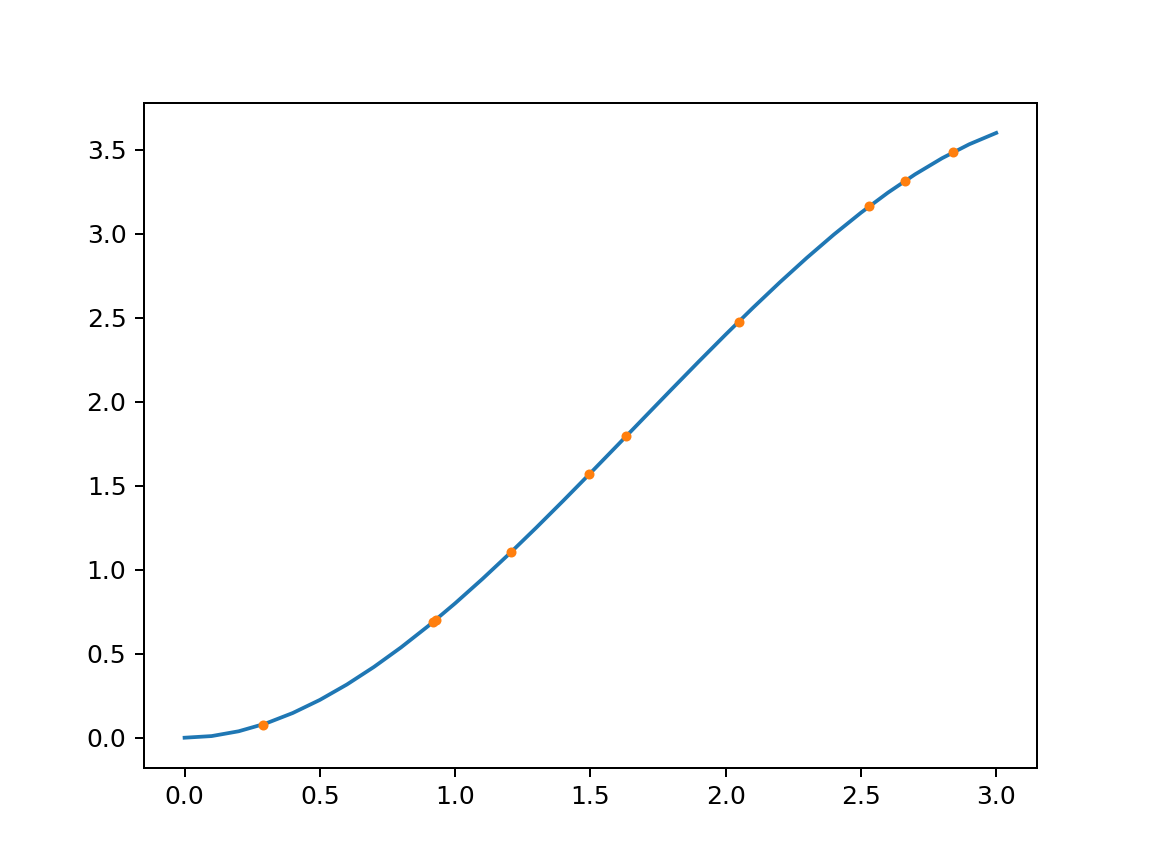

In [2]:

x_dense = torch.arange(0,3.01,0.1)
f = lambda x: x ** 2 - 0.2 * x**3
plt.plot(x_dense, f(x_dense))

n_samples = 10
samples_x = torch.rand(n_samples) * 2.8 + 0.1

# Sample, but lower
samples_y = f(samples_x)

plt.plot(samples_x, samples_y, '.')


<IPython.core.display.Javascript object>


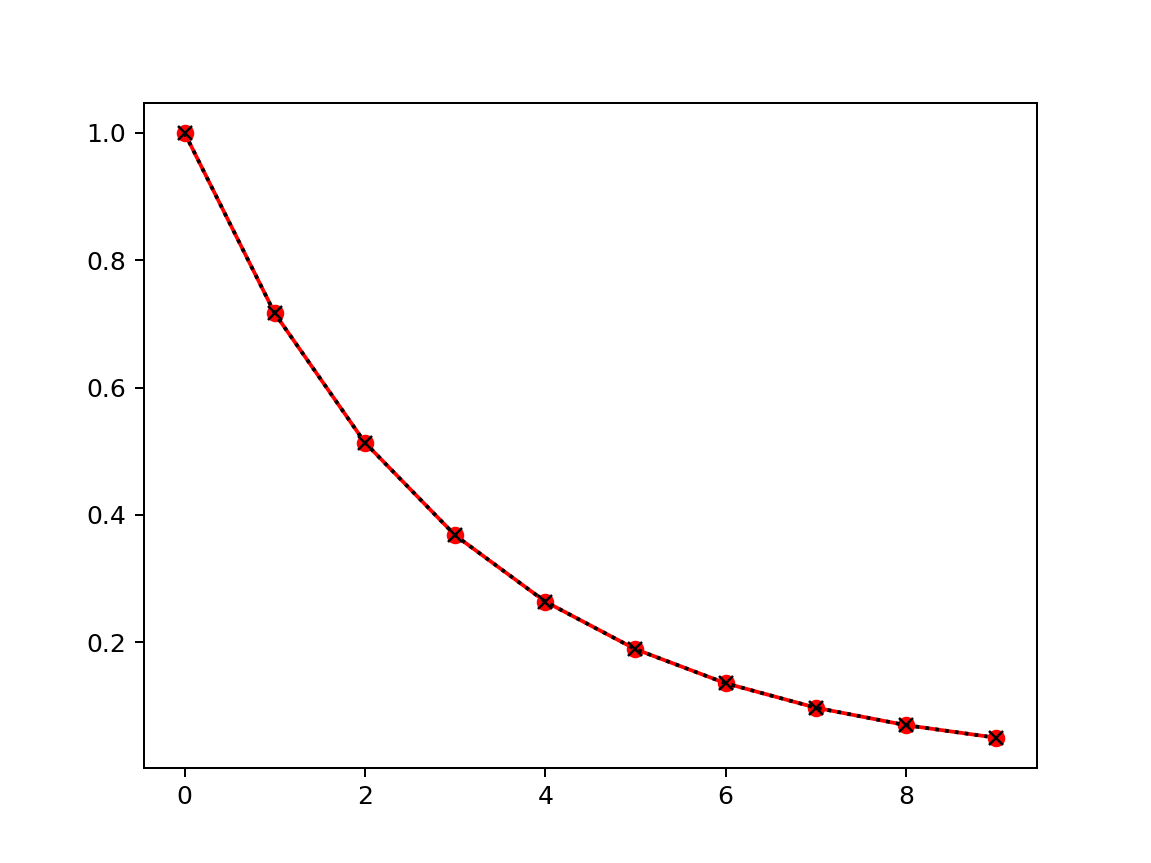

In [3]:
def interp1d(x, y, xnew):
    """
    PyTorch interp1d, as in scipy.interpolate(x,y,assume_sorted=True)(xnew)
    
    Limited to 1D-1D for now, should not be hard to enhance if needed
    
    github.com/awf
    """
    # For each point in x, we want to find index of the knot above it, and hence that below it
    # so knots_x[ind-1] <= x < knots_x[ind]
    inds = torch.bucketize(xnew, x, right=True)

    # Call those points xlo, xhi
    xlo = x[inds-1]
    xhi = x[inds]
    ylo = y[inds-1]
    yhi = y[inds]
    
    dx = xhi - xlo
    dy = yhi - ylo

    # Then t = (xnew - xlo)/dx
    # ynew = ylo + t * dy
    t = (xnew - xlo) / dx
    return ylo + t * dy

def test_interp1d():
    # scipy example from https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
    import scipy.interpolate
    import numpy as np
    x = np.arange(0, 10)
    y = np.exp(-x/3.0)
    f = scipy.interpolate.interp1d(x, y)
    xnew = np.arange(0, 9, 0.1)
    ynew = f(xnew)   # use interpolation function returned by `interp1d`

    # Now do it with torch
    tx = torch.arange(0, 10)
    ty = torch.exp(-tx/3.0)
    txnew = torch.arange(0, 9, 0.1)
    tynew = interp1d(tx,ty,txnew)
    plt.figure()
    plt.plot(x, y, 'ro', xnew, ynew, 'r-',
             tx, ty, 'kx', txnew, tynew, 'k:')
    plt.show()
    
test_interp1d()

<IPython.core.display.Javascript object>


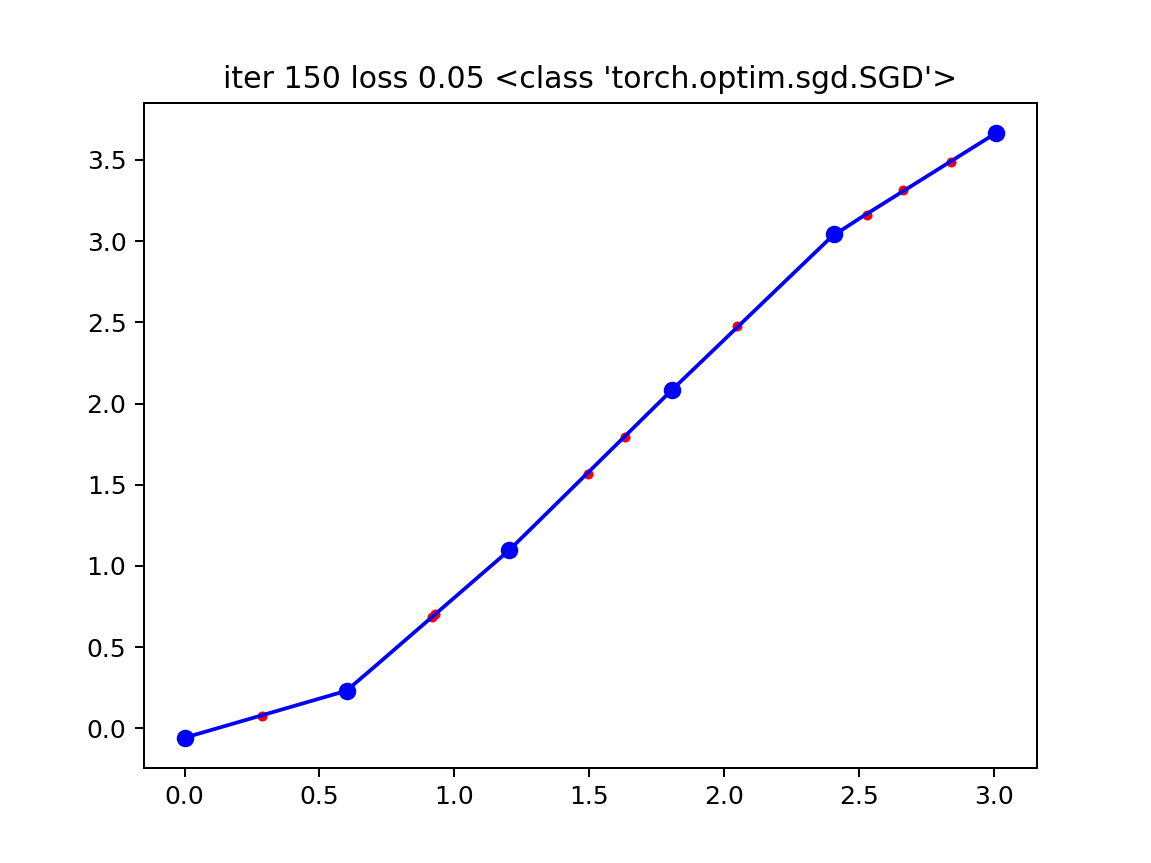

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.01
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)

In [8]:


# Fitting.   Define approximator.
knots_x = torch.linspace(0.0,3.01,6)

# Model is piecewise linear interpolation between knots ("linear spline")
model = lambda weights, x: interp1d(knots_x, weights, x)

# Define losses

# 1. Data term: function should agree with samples
loss_data = lambda weights: (model(weights, samples_x) - samples_y).abs().sum()

# 2. Monotonicity: pay a penalty wherever weights[i+1] < weights[i]
loss_monotonic = lambda weights: torch.relu(weights[:-1] - weights[1:]).sum()

loss = lambda weights: loss_data(weights) + loss_monotonic(weights)


# Initial estimate of parameters
torch.manual_seed(41)
weights = torch.cumsum(torch.randn(knots_x.shape),0)

weights.requires_grad = True

fig = plt.figure()
with torch.no_grad():
    samples_pred_y = model(weights, samples_x)
    plt.plot(samples_x, samples_y, '.', samples_x, samples_pred_y, 'x')
    y_dense = model(weights, x_dense)
    plt.plot(x_dense, y_dense, '-', knots_x, weights, 'o')


# Initialize optimizer

#optimizer = torch.optim.Adam((weights,), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.SGD((weights,), lr=0.01,momentum=0.9)
iter_count = 0
optimizer

In [16]:
for k in range(150):
    # Run one iteration
    iter_count += 1
    optimizer.zero_grad()
    loss_value = loss(weights)
    loss_value.backward()
    optimizer.step()

    with torch.no_grad():
        fig.clear()
        plt.plot(samples_x, samples_y, 'r.')
        plt.plot(x_dense, model(weights, x_dense), 'b-', knots_x, weights, 'bo')
        plt.title(f'iter {iter_count} loss {loss_value:.2f} {optimizer.__class__}')
        plt.show()
        fig.canvas.draw()


<IPython.core.display.Javascript object>


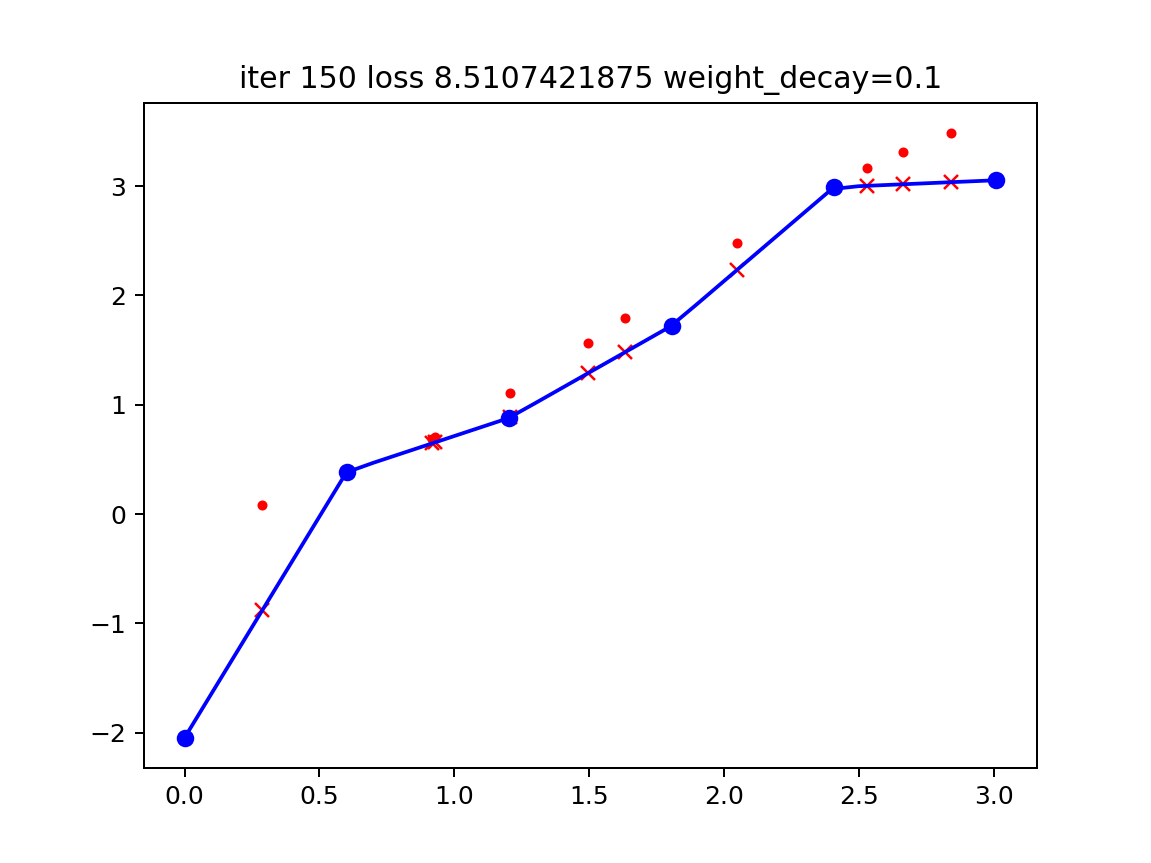

In [17]:
# One-sided Fitting. Same model as above

# Define losses

# 1. Data term: function should not exceed samples: relu(data - model)
p = 2 # p-norm loss on one-sided term.  In principle, we should pay infinity for violating the bound, but quadratic should be enough
loss_data = lambda weights: (torch.relu(samples_y - model(weights, samples_x)) ** p).sum()

# 2. Monotonicity: pay a penalty wherever weights[i+1] < weights[i]
loss_monotonic = lambda weights: torch.relu(weights[:-1] - weights[1:]).sum()

weight_decay = 0.1
# 3. Weight decay: "gravity" to pull model down
loss_weight_decay = lambda weights: weights.sum()

loss = lambda weights: loss_data(weights) + loss_monotonic(weights) + loss_weight_decay(weights)

# Initial estimate of parameters
torch.manual_seed(41)
weights = torch.cumsum(torch.randn(knots_x.shape),0)

# Parameters => requires gradient
weights.requires_grad = True

# Plot the samples, their model predictions, and the model parameters (i.e. spline knots)
fig = plt.figure()
with torch.no_grad():
    samples_pred_y = model(weights, samples_x)
    plt.plot(samples_x, samples_y, '.', samples_x, samples_pred_y, 'x')
    y_dense = model(weights, x_dense)
    plt.plot(x_dense, y_dense, '-', knots_x, weights, 'o')


# Initialize optimizer

#optimizer = torch.optim.Adam((weights,), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
optimizer = torch.optim.SGD((weights,), lr=0.01,momentum=0.9)
iter_count = 0

for k in range(150):
    # Run one iteration
    iter_count += 1
    optimizer.zero_grad()
    loss_value = loss(weights)
    loss_value.backward()
    optimizer.step()

    with torch.no_grad():
        fig.clear()
        plt.plot(samples_x, samples_y, 'r.', samples_x, model(weights, samples_x), 'rx')
        plt.plot(x_dense, model(weights, x_dense), 'b-', knots_x, weights, 'bo')
        plt.title(f'iter {iter_count} loss {loss_value:.3f} weight_decay={weight_decay}')
        plt.show()
        fig.canvas.draw()
